<a href="https://colab.research.google.com/github/RRADJon/pyPBPK_dev/blob/main/pyPBPK_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
# @markdown **PBPK Model Architecture, Assumptions, and Functions**

# @markdown### **Model Structure and Assumptions**
# @markdown This is a **whole-body physiological based pharmacokinetic (PBPK) model** consisting of 16 anatomical compartments arranged in a parallel configuration, connected by the systemic circulation.
# @markdown
# @markdown **Compartmental Logic:** The model tracks drug mass across 4 GI Luminal segments (Stomach, Duodenum, Jejunum, Ileum), 9 Tissues (Liver, Kidney, Muscle, Adipose, Brain, Rest-of-Body, and 4 GI-specific tissues), and 2 Central Blood compartments (Arterial, Venous).

# @markdown **Perfusion-Limited Kinetics:** Assumes that the cell membrane barrier is negligible. The rate-limiting step for drug distribution is **blood flow ($Q$)** to the organ. The drug concentration in the venous blood leaving a tissue is assumed to be in equilibrium with the concentration in that tissue, governed by the **Tissue-to-Plasma Partition Coefficient ($K_p$)**.

# @markdown **Hepatic Clearance (Well-Stirred Model):** Metabolism is localized to the liver. The model assumes the liver is a "well-stirred" reactor where the unbound concentration in the liver is responsible for clearance. It accounts for:

# @markdown    * Intrinsic clearance ($CL_{int}$) scaled by microsomal protein per gram of liver (MPPGL).

# @markdown   * The **First-Pass Effect**, where a fraction of the drug is metabolized before reaching systemic circulation ($F_h = 1 - E_h$).

# @markdown **Renal Clearance:** Modeled as a first-order "sink" from the arterial compartment, specifically acting on the **unbound fraction ($f_u$)** of the drug.

# @markdown **Gastrointestinal Transit & Absorption:** **Transit:** Follows a first-order transit model where drug moves from stomach to ileum.
# @markdown **Absorption:** Driven by either a rate constant ($K_a$) or effective permeability ($P_{eff}$).
# @markdown **Solubility-Limited:** The model accounts for solubility-limited absorption, where the amount available for uptake is capped by the drug’s solubility in the luminal volume of each segment.

# @markdown### **Model Parameters**
# @markdown* **Physiological Parameters:** Organ volumes ($V_c$) and blood flows ($Q_c$) are derived from ICRP 89 reference values for a 70kg adult, with allometric scaling ($BW^{0.75}$) applied for population variability.
# @markdown* **Drug-Specific Parameters:** Requires $K_p$ values (calculated via Lipophilicity/LogP), Plasma Protein Binding ($f_u$), and enzyme-specific $CL_{int}$ (typically from *in vitro* human liver microsomes).

# @markdown### **Key Functions**
# @markdown **`sample_physiology`**: Performs allometric scaling based on weight and age. It introduces inter-individual variability (IIV) by applying a normal distribution to body weight and adjusting cardiac output and organ volumes accordingly.

# @markdown **`sample_enzyme_activity`**: Introduces metabolic variability using a **Log-Normal distribution**. This simulates the "Fast/Slow Metabolizer" phenotypes found in human populations.

# @markdown **`pbpk_ode`**: The core numerical engine. It solves 16 simultaneous mass-balance equations:

# @markdown  $$\frac{dA_{tissue}}{dt} = Q_{tissue} \cdot \left( C_{art} - \frac{C_{tissue}}{K_p \cdot BP} \right)$$

# @markdown **`solve_multi_dose`**: A wrapper for the ODE solver that handles discontinuous events (repeated dosing). It resets the initial conditions at each dosing interval to simulate drug accumulation over time.
# @markdown

# @markdown### **Assumptions & Limitations**
# @markdown1.  **Homogeneity:** Each organ is a well-mixed compartment; no spatial gradients are modeled within a tissue.
# @markdown2.  **Blood-to-Plasma Ratio ($BP$):** Currently assumed to be 1.0, meaning drug distributes equally between red blood cells and plasma.
# @markdown3.  **No Active Transport:** The model assumes passive diffusion; carrier-mediated transport (e.g., P-gp efflux or OATP uptake) is not explicitly modeled unless reflected in the $P_{eff}$ or $CL_{int}$ inputs.

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import copy

# --- 1. Global/Base Physiology Parameters ---

# Base reference physiology (70kg adult)
physiology_base = {
    "cardiac_output": 420,   #reference values from ICRP 89 (390 to 450)
    "organs": {
        "liver":   {"V": 1.8, "Q_frac": 0.25},  #1.8L ICRP 89
        "kidney":  {"V": 0.31, "Q_frac": 0.195}, #0.31L ICRP 89
        "stomach": {"V": 0.5, "Q_frac": 0.01},
        "duodenum":{"V": 0.3, "Q_frac": 0.015},
        "jejunum": {"V": 0.6, "Q_frac": 0.035},
        "ileum":   {"V": 0.6, "Q_frac": 0.03},
        "muscle":  {"V": 29,  "Q_frac": 0.145},   #29L ICRP 89
        "adipose": {"V": 18,  "Q_frac": 0.05},
        "brain":   {"V": 1.4, "Q_frac": 0.08},
        "rest":    {"V": 15,  "Q_frac": None}
    },
    "blood": {"V_art": 1.5, "V_ven": 3.0}
}

# Define the order and index of the states
state_names = [
    "stomach_lumen", "duodenum_lumen", "jejunum_lumen", "ileum_lumen",
    "liver", "kidney", "stomach", "duodenum", "jejunum", "ileum",
    "muscle", "adipose", "brain", "rest", "arterial", "venous", "cm_absorbed"
]
state_index = {name: i for i, name in enumerate(state_names)}
n_states = len(state_names)
GI_segments = ["stomach", "duodenum", "jejunum", "ileum"]

GI_LUMEN_VOLUMES = {
    "stomach": 0.15,
    "duodenum": 0.05,
    "jejunum": 0.13,
    "ileum": 0.18
}


# Enzyme fractions (for CLint calculation)
enzyme_contributions = {
    "CYP3A4": 0.8,
    "CYP2D6": 0.15,
    "CYP2C9": 0.05
}

# --- 2. Physiological and Enzyme Sampling Functions ---

def sample_enzyme_activity():
    return {
        #"CYP3A4": lognorm(s=0.25, scale=1).rvs(),
        #"CYP2D6": lognorm(s=0.45, scale=1).rvs(),
        #"CYP2C9": lognorm(s=0.30, scale=1).rvs()
        "CYP3A4": np.random.lognormal(mean=0, sigma=0.3), # ~30% variability
        "CYP2D6": np.random.lognormal(mean=0, sigma=0.5), # ~50% variability
        "CYP2C9": np.random.lognormal(mean=0, sigma=0.3)
    }

def calculate_CLint_total(drug, enzyme_activity):
# ... (code omitted for brevity) ...
    CL_int_total = 0.0
    for enz, frac in enzyme_contributions.items():
        CLint = drug["CLint"].get(enz, 0.0) # CLint is in µL/min/mg protein
        CL_int_total += frac * CLint * enzyme_activity.get(enz, 1.0)
    return CL_int_total

def sample_physiology(base_physiology, drug, age=35, weight=70):
    # Add random weight variability (±15% CV)
    sampled_weight = np.random.normal(weight, weight * 0.15)
    phys = {"age": age, "weight": max(40, sampled_weight)}

    #phys = {"age": age, "weight": weight}

    # Cardiac Output scaling (allometric)
    CO_base = base_physiology["cardiac_output"]
    #phys["cardiac_output"] = CO_base * (weight / 70) ** 0.75
    phys["cardiac_output"] = base_physiology["cardiac_output"] * (phys["weight"] / 70) ** 0.75

    # Liver blood flow age correction
    age_factor = max(0.7, 1 - 0.005 * max(age - 30, 0))

    phys["blood"] = base_physiology["blood"].copy()
    phys["organs"] = {}

    total_frac = 0
    sampled_fracs = {}

    for organ, props in base_physiology["organs"].items():
        phys["organs"][organ] = props.copy()
        phys["organs"][organ]["V"] *= (weight / 70)

        if props.get("Q_frac") is not None:
            frac = props["Q_frac"]
            if organ == "liver":
                frac *= age_factor
            sampled_fracs[organ] = frac
            total_frac += frac

    # Normalize flows to cardiac output
    for organ, frac in sampled_fracs.items():
        phys["organs"][organ]["Q"] = phys["cardiac_output"] * frac / total_frac

    # Rest compartment flow
    phys["organs"]["rest"]["Q"] = phys["cardiac_output"] - sum(
        phys["organs"][o]["Q"] for o in sampled_fracs
    )
    return phys

def calculate_KA_from_Permeability(P_eff_cm_min, V_gut_L):
    """
    Calculates the absorption rate constant (KA in 1/h) from P_eff.
    """
    S_V_factor = 75 # 1/cm - Simplified gut surface area to volume ratio
    KA = P_eff_cm_min * S_V_factor * 60
    return KA

def renal_clearance_Amount_h(C_art, drug):
    """
    Renal Clearance (Amount/h) - Sink from Arterial compartment.
    """
    fu_plasma = drug["fu_plasma"]
    CL_renal_unbound = drug["CL_renal"] # L/h
    Rate_elim = CL_renal_unbound * C_art * fu_plasma
    return Rate_elim

def calculate_CL_H_eff(drug, physiology, enzyme_activity):
    """
    Calculates the total effective hepatic clearance (L/h) using the well-stirred model.
    """
    CL_int_mic = calculate_CLint_total(drug, enzyme_activity)

    # Robust CLint to L/h conversion (Copied from the ODE for consistency)
    if "physchem" in drug and "MPPGL" in drug["physchem"]:
        MPPGL = drug["physchem"].get("MPPGL", 40)
        Liver_Weight = drug["physchem"].get("liver_weight", 1500)
        scaling_factor = (MPPGL * Liver_Weight / 1000) * (60 / 1000000)
        CL_int_total_L_h = CL_int_mic * scaling_factor
    else:
        CL_int_total_L_h = CL_int_mic

    fu = drug["fu_plasma"]
    Qh = physiology["organs"]["liver"]["Q"]

    # Well-Stirred Extraction Ratio (E)
    E = (fu * CL_int_total_L_h) / (Qh + fu * CL_int_total_L_h)

    # Effective Hepatic Clearance (CL_H)
    CL_H = Qh * E
    return CL_H, E

# --- 3. PBPK ODE (Core Model) ---

def pbpk_ode(t, y, physiology, drug, enzyme_activity):

    dydt = np.zeros_like(y)
    C_art = y[state_index["arterial"]] / physiology["blood"]["V_art"]
    C_ven = y[state_index["venous"]] / physiology["blood"]["V_ven"]
    Q_H_art = physiology["organs"]["liver"]["Q"]
    Q_H_total = Q_H_art + sum(physiology["organs"][o]["Q"] for o in GI_segments)
    portal_flow_to_liver_mass = 0.0
    venous_return = 0.0

    # --- Clearance Pre-calculation  ---
    CL_int_mic = calculate_CLint_total(drug, enzyme_activity)
    fu_plasma = drug["fu_plasma"]

    # Robust check for CLint scaling (µL/min/mg protein to L/h)
    if "physchem" in drug and "MPPGL" in drug["physchem"]:
        MPPGL = drug["physchem"].get("MPPGL", 40)
        Liver_Weight = drug["physchem"].get("liver_weight", 1500)
        scaling_factor = (MPPGL * Liver_Weight / 1000) * (60 / 1000000)
        CL_int_total_L_h = CL_int_mic * scaling_factor
    else:
        # Assume CL_int is already scaled to L/h for drugs without physchem
        CL_int_total_L_h = CL_int_mic

    # --- 1. Luminal Transit and Absorption ---
    T_rate_stomach = 0.2  # Slow gastric emptying (h^-1)
    T_rate_intestine = 2.0 # Fast intestinal transit (h^-1)

    # Solubility (mg/mL → mg/L)
    S_mg_L = drug["physchem"]["solubility_mg_per_mL"] * 1000

    for i, segment in enumerate(GI_segments):
        lumen_i = state_index[segment + "_lumen"]
        tissue_i = state_index[segment]

        V_tissue = physiology["organs"][segment]["V"]
        Q_tissue = physiology["organs"][segment]["Q"]
        Kp_tissue = drug["Kp"].get(segment, 1.0)

        # Absorption Rate
        # Apply bioavailability factor (
        # Lumen volume (L)
        V_lumen = GI_LUMEN_VOLUMES[segment]


        # Maximum dissolved amount (mg)
        A_dissolved_max = S_mg_L * V_lumen

        # Actual dissolved drug available for absorption
        V_lumen = GI_LUMEN_VOLUMES[segment]
        A_dissolved = min(y[lumen_i], A_dissolved_max)

        # Bioavailability factor (optional scalar)
        absorption_rate = drug["KA"] * A_dissolved
        dydt[state_index["cm_absorbed"]] = absorption_rate


        # 1b. Luminal ODE
        if i == 0: # Stomach
            lumen_inflow = 0.0
            lumen_outflow = T_rate_stomach * y[lumen_i]
        else: # Intestine (Duodenum, Jejunum, Ileum)
            prev_segment = GI_segments[i-1]
            prev_lumen_i = state_index[prev_segment + "_lumen"]

            # Inflow is Outflow from previous segment
            transit_rate = T_rate_stomach if i == 1 else T_rate_intestine
            lumen_inflow = transit_rate * y[prev_lumen_i]

            lumen_outflow = T_rate_intestine * y[lumen_i]

        dydt[lumen_i] = lumen_inflow - absorption_rate - lumen_outflow

        # 1c. GI Tissue ODE
        C_org = y[tissue_i] / V_tissue
        C_ven_org = C_org / Kp_tissue

        # Mass transfer via Perfusion (In - Out)
        perfusion_mass_change = Q_tissue * (C_art - C_ven_org)

        # ODE: Absorption + Perfusion Mass Change
        dydt[tissue_i] = absorption_rate + perfusion_mass_change

        # GI Outflow (to Portal Vein)
        portal_flow_to_liver_mass += Q_tissue * C_ven_org

    # --- 2. Organ Perfusion and Clearance (Non-GI) ---
    non_gi_organs = [o for o in physiology["organs"] if o not in GI_segments]

    for organ in non_gi_organs:
        props = physiology["organs"][organ]
        i = state_index[organ]
        V = props["V"]
        Q = props["Q"]
        Kp = drug["Kp"].get(organ, 1.0)

        C_org = y[i] / V
        C_ven_org = C_org / Kp # Whole blood concentration leaving organ

        inflow_outflow = Q * (C_art - C_ven_org)

        if organ == "liver":
            # Liver Mass Balance
            Liver_In = (Q_H_art * C_art) + portal_flow_to_liver_mass
            Liver_Out = Q_H_total * C_ven_org

            # Elimination Rate (Amount/h) = CL_int_total_L_h * C_unbound_liver_plasma
            Kp_liver = drug["Kp"]["liver"]
            C_unbound_liver = (C_org / Kp_liver) * fu_plasma
            C_unbound_liver = C_org / Kp * fu_plasma
            elim_rate_h = CL_int_total_L_h * C_unbound_liver

            dydt[i] = Liver_In - Liver_Out - elim_rate_h

            venous_return += Liver_Out

        else: # All other organs (kidney, muscle, adipose, brain, rest)
            dydt[i] = inflow_outflow
            venous_return += Q * C_ven_org

    # 3. Renal Clearance: Sink from the Arterial Compartment
    elim_renal = renal_clearance_Amount_h(C_art, drug)

    # 4. Central Compartments (Systemic Blood)
    dydt[state_index["venous"]] = venous_return - physiology["cardiac_output"] * C_ven
    dydt[state_index["arterial"]] = physiology["cardiac_output"] * (C_ven - C_art) - elim_renal

    return dydt

# --- 4. Main Execution Function ---

def run_and_evaluate_pbpk(drug_params, physiology_base, t_eval, n_individuals=200):
    """ Runs single-individual and population PBPK simulations and extracts key metrics. """

    # Get the t_end dynamically from the t_eval array
    t_end_dynamic = t_eval[-1]
    single_enzyme_activity_ref = {"CYP3A4": 1.0, "CYP2D6": 1.0, "CYP2C9": 1.0}
    drug_params_mech = copy.deepcopy(drug_params)

    # Calculate KA from P_eff if available
    if "physchem" in drug_params_mech and "P_eff_transcellular" in drug_params_mech["physchem"]:
        P_eff = drug_params_mech["physchem"]["P_eff_transcellular"]
        V_gut_total = sum(physiology_base["organs"][seg]["V"] for seg in GI_segments)
        drug_params_mech["KA"] = calculate_KA_from_Permeability(P_eff, V_gut_total)

    # --- HELPER FUNCTION: Multi-Dose Solver ---
    def solve_multi_dose(phys, drug, enzyme, t_eval_points):
        y_current = np.zeros(n_states)
        full_t = []
        full_y = []

        dose_mg = drug["dose_mg"]
        # Default to a single dose at t=0 if dose_times is missing
        dose_times = drug.get("dose_times", [0])
        t_stop = t_eval_points[-1]

        # We solve segment by segment between dose events
        event_times = sorted([t for t in dose_times if t < t_stop]) + [t_stop]

        for i in range(len(event_times) - 1):
            t_start = event_times[i]
            t_next = event_times[i+1]

            # 1. Administer Dose
            if drug["route"] == "oral":
                y_current[state_index["stomach_lumen"]] += dose_mg
            else:
                y_current[state_index["venous"]] += dose_mg

            # 2. Solve Interval
            t_span = [t_start, t_next]
            t_segment = t_eval_points[(t_eval_points >= t_start) & (t_eval_points <= t_next)]

            if len(t_segment) > 0:
                sol = solve_ivp(pbpk_ode, t_span, y_current, t_eval=t_segment,
                                args=(phys, drug, enzyme), method="LSODA")
                full_t.extend(sol.t)
                full_y.append(sol.y)
                y_current = sol.y[:, -1] # Set start for next segment

        return np.hstack(full_y)

    # --- 1. Single-Individual Simulation ---
    drug = drug_params_mech
    physiology_single = sample_physiology(physiology_base, drug)

    # FIX: Pull values from the 'drug' dictionary or global scope
    current_dose = drug.get("dose_mg", 100)
    num_doses = len(drug.get("dose_times", [0]))
    is_repeated = len(drug.get("dose_times", [0])) > 1

    if repeat_doses: # This uses the boolean from your UI
        y_full_single = solve_multi_dose(physiology_single,
                                         drug,
                                         single_enzyme_activity_ref,
                                         t_eval)
        final_absorbed = y_full_single[state_index["cm_absorbed"], -1]
    else:
        y0 = np.zeros(n_states)
        if drug["route"] == "oral":
            y0[state_index["stomach_lumen"]] = current_dose
        else:
            y0[state_index["venous"]] = current_dose

        sol = solve_ivp(
            pbpk_ode, [0, t_end_dynamic], y0, t_eval=t_eval,
            args=(physiology_single, drug, single_enzyme_activity_ref), method="LSODA"
        )
        y_full_single = sol.y
        final_absorbed = y_full_single[state_index["cm_absorbed"]][-1]

    # --- Unified Metrics Calculation ---
    C_art_single = y_full_single[state_index["arterial"]] / physiology_single["blood"]["V_art"]

    # FIX: Use local variables to avoid UnboundLocalError
    total_administered = current_dose * (num_doses if repeat_doses else 1)
    fa = final_absorbed / total_administered if total_administered > 0 else 0

    # Calculate Hepatic Extraction (Eh) and Fraction escaping liver (fh)
    CL_H_eff_single, Eh = calculate_CL_H_eff(drug, physiology_single, single_enzyme_activity_ref)
    fh = 1 - Eh

    # Emergent Bioavailability
    emergent_F = fa * fh  # Assumes gut metabolism (fg) is 1.


    # Handle the case where Cmax is near zero
    if np.max(C_art_single) < 1e-12:
         total_AUC_single = 0
         CL_total_single = np.inf
         Tmax_single = 0
         CL_H_eff_single = 0
         Hepatic_E_single = 0
    else:
        total_AUC_single = np.trapezoid(C_art_single, t_eval)
        CL_total_single = current_dose / total_AUC_single
        Tmax_single = t_eval[np.argmax(C_art_single)]
        CL_H_eff_single, Hepatic_E_single = calculate_CL_H_eff(drug, physiology_single, single_enzyme_activity_ref)

    single_results = {
        "Drug": drug["name"],
        "Simulation Type": "Single Individual",
        "KA (1/h) Used": drug["KA"],
        "Plasma Cmax (mg/L)": np.max(C_art_single),
        "Plasma AUC (mg*h/L)": total_AUC_single,
        "CL_total (L/h)": CL_total_single,
        "CL_H_eff (L/h)": CL_H_eff_single,
        "Tmax (h)": Tmax_single,
        "Hepatic Extraction Ratio": Hepatic_E_single
    }
    # Add to results dictionary
    single_results["Emergent F"] = emergent_F
    single_results["Fraction Absorbed (fa)"] = fa

    # --- 2. Population Simulation  ---

    Cmax_list, AUC_list, CL_H_eff_list, Tmax_list = [], [], [], []
    plasma_profiles_list = []

    for _ in range(n_individuals):
        phys_i = sample_physiology(physiology_base, drug_params_mech)
        enzyme_activity_i = sample_enzyme_activity()

        if repeat_doses == True:
            # REPLACED standard solve_ivp with multi-dose helper
            y_pop_i = solve_multi_dose(phys_i, drug_params_mech, enzyme_activity_i, t_eval)
            plasma_C = y_pop_i[state_index["arterial"]] / phys_i["blood"]["V_art"]
        elif repeat_doses == False:
            y0_i = np.zeros(n_states)
            if drug["route"] == "oral":
              y0_i[state_index["stomach_lumen"]] = current_dose
            elif drug["route"] == "iv":
              y0_i[state_index["venous"]] = current_dose

            # FIX: Use [0, t_end_dynamic] for t_span
            sol_pop = solve_ivp(
                pbpk_ode, [0, t_end_dynamic], y0_i, t_eval=t_eval,
                args=(phys_i, drug_params_mech, enzyme_activity_i), method="LSODA"
            )
            plasma_C = sol_pop.y[state_index["arterial"]] / phys_i["blood"]["V_art"]

        if np.max(plasma_C) > 1e-12:
            Cmax_list.append(np.max(plasma_C))
            AUC_list.append(np.trapezoid(plasma_C, t_eval))
            Tmax_list.append(t_eval[np.argmax(plasma_C)])
            CL_H_eff_i, _ = calculate_CL_H_eff(drug, phys_i, enzyme_activity_i)
            CL_H_eff_list.append(CL_H_eff_i)

            plasma_profiles_list.append(plasma_C)

    # Convert list of vectors to a 2D array (Individuals x Time)
    pop_profiles_2d = np.array(plasma_profiles_list)

    Cmax_pop = np.array(Cmax_list)
    AUC_pop = np.array(AUC_list)
    CL_total_pop = current_dose / AUC_pop if len(AUC_pop) > 0 and (AUC_pop > 1e-12).any() else np.array([])

    # --- Calculate Geometric Mean and GCV% ---
    def calculate_geometric_stats(data):
        data = data[data > 1e-12]
        if data.size == 0:
            return np.nan, np.nan
        log_data = np.log(data)
        geom_mean = np.exp(np.mean(log_data))
        geom_sd = np.sqrt(np.exp(np.std(log_data, ddof=1)**2) - 1)
        gcv_percent = geom_sd * 100
        return geom_mean, gcv_percent

    Cmax_GM, Cmax_GCV = calculate_geometric_stats(Cmax_pop)
    AUC_GM, AUC_GCV = calculate_geometric_stats(AUC_pop)
    CL_total_GM, CL_total_GCV = calculate_geometric_stats(CL_total_pop)

    # --- Consolidate Report ---
    report = []

    # Population Median/CI
    # Population Median with 90% CI for all major parameters
    report.append({
        "Drug": drug["name"],
        "Type": "Population Median",
        "Cmax (mg/L)": f"{np.percentile(Cmax_pop, 50):.2f} [{np.percentile(Cmax_pop, 5):.2f}-{np.percentile(Cmax_pop, 95):.2f}]",
        "AUC (mg*h/L)": f"{np.percentile(AUC_pop, 50):.2f} [{np.percentile(AUC_pop, 5):.2f}-{np.percentile(AUC_pop, 95):.2f}]",
        "CL_total (L/h)": f"{np.percentile(CL_total_pop, 50):.2f} [{np.percentile(CL_total_pop, 5):.2f}-{np.percentile(CL_total_pop, 95):.2f}]",
        "Tmax (h)": f"{np.percentile(Tmax_list, 50):.2f} [{np.percentile(Tmax_list, 5):.2f}-{np.percentile(Tmax_list, 95):.2f}]",
        "Hepatic Ext. Ratio": np.nan,
        "90% CI/GCV%": "Included in columns above"
    })

    # Population Variability
    report.append({
        "Drug": drug["name"], "Type": "Population Variability",
        "Cmax (mg/L)": Cmax_GM, "AUC (mg*h/L)": AUC_GM,
        "CL_total (L/h)": CL_total_GM, "Tmax (h)": np.nan,
        "Hepatic Ext. Ratio": np.nan,
        "90% CI/GCV%": f"GCV%: {Cmax_GCV:.2f}",
    })


    return single_results, pd.DataFrame(report), Cmax_pop, AUC_pop, t_eval, pop_profiles_2d, C_art_single

In [78]:
#@title Cell 2: 💊 Drug Input and Simulation Parameters

#@markdown **⚙️Simulation Setup**

#@markdown **Number of Individuals:** The size of the simulated patient population ($N$). Higher $N$ leads to smoother population curves but takes longer to run.
n_pop_indiv = 40 #@param {type:"slider", min:10, max:500, step:10}
#@markdown **Simulation Time ($t_{end}$ in h):** The total duration of the PK simulation.
t_end = 96 #@param {type:"slider", min:12, max:168, step:12}
n_points = 500
t_eval = np.linspace(0, t_end, n_points)


#@markdown **Drug Properties:** input phyisical pharmacological properties for the drug
#@markdown
#@markdown Drug properties can often be found for previously studied chemicals at Pubchem, additionally tools like ADMETlab3.0 help to predict unknown values.


# --- 2. Drug Properties (The New Drug) ---
Drug_Name = "Alfentanil" #@param {type:"string"}
#@markdown Route/Dose: Defines how the drug enters the system (Oral: Stomach Lumen; IV: Venous Blood).
Route_of_Administration = "oral" #@param ["oral", "iv"]
Dose_mg = 100 #@param {type:"number", min:1, max:1000}
repeat_doses= True #@param {type: "boolean"}
Number_of_Doses = 5 #@param {type:"slider", min:1, max:20, step:1}
Dosing_Interval_h = 48 #@param {type:"number"}

# Create a list of dose times
dose_times = [i * Dosing_Interval_h for i in range(Number_of_Doses)]

# Solubility at reference pH
Solubility_mg_per_mL = 0.034  #@param {type:"number"}
Reference_pH = 7.4 #@param {type:"number"}
#@markdown logP (octanol/water)
Lipophilicity_logP = 2.2  #@param {type:"number"}

Molecular_Weight_g_per_mol = 416.5 #@param {type:"number"}
Is_Small_Molecule = True #@param {type:"boolean"}



#@markdown $CL_{renal}$ (Renal Clearance, $L/h$): The rate at which the unbound drug is filtered and eliminated by the kidney.
Fraction_Unbound_Plasma = 0.1  #@param {type:"number"}
Plasma_Protein_Binding_Partner = "Albumin" #@param {type:"string"}



#@markdown $P_{eff}$ (Effective Permeability, $cm/min$): Used to calculate $KA$. Represents the drug's ability to cross the gut wall.
P_eff_transcellular_cm_min = 5.7e-4 #@param {type:"number"}
#@markdown Explicit oral F or bioavailability
Bioavailability_F = 1 #@param {type:"number"}


# === Clearance ===
#@markdown $CL_{renal}$ (Renal Clearance, $L/h$): The rate at which the unbound drug is filtered and eliminated by the kidney.
Renal_Clearance_CL_renal_L_h = 0.15 #@param {type:"number"}
#@markdown $CL_{int}$ (µL/min/mg protein) for key CYP enzymes: Enter the unbound intrinsic clearance for the primary metabolizing enzymes. Inter-individual variability is applied to these enzyme activities.
CLint_CYP3A4 = 10 #@param {type:"number"}
CLint_CYP2D6 = 5  #@param {type:"number"}
CLint_CYP2C9 = 1  #@param {type:"number"}


# --- Derived / Mapped Parameters ---


def logP_to_Kp(logP):
    """
    Simple Poulin-Theil–style heuristic.
    PK-Sim computes this internally; this is a transparent surrogate.
    """
    return 1 + 10 ** logP


# Tissue Kp derived from lipophilicity
Kp_map = {
    "liver": logP_to_Kp(Lipophilicity_logP) * 0.8,
    "kidney": logP_to_Kp(Lipophilicity_logP) * 0.6,
    "muscle": logP_to_Kp(Lipophilicity_logP) * 0.4,
    "adipose": logP_to_Kp(Lipophilicity_logP) * 1.5,
    "stomach": 2.0,
    "duodenum": 4.0,
    "jejunum": 4.5,
    "ileum": 4.0,
    "brain": 1.0,
    "rest": 2.5
}


# --- Construct Drug Dictionary ---


new_drug_params = {
    "name": Drug_Name,
    "route": Route_of_Administration,
    "dose_mg": Dose_mg,


    # PK-Sim–matched fields
    "physchem": {
        "solubility_mg_per_mL": Solubility_mg_per_mL,
        "reference_pH": Reference_pH,
        "logP": Lipophilicity_logP,
        "MW": Molecular_Weight_g_per_mol,
        "is_small_molecule": Is_Small_Molecule,
        "P_eff_transcellular": P_eff_transcellular_cm_min,
        "F": Bioavailability_F,
        "MPPGL": 40,
        "liver_weight": 1500
    },
    "fu_plasma": Fraction_Unbound_Plasma,
    "plasma_binding_partner": Plasma_Protein_Binding_Partner,


    "CL_renal": Renal_Clearance_CL_renal_L_h,


    "CLint": {
        "CYP3A4": CLint_CYP3A4,
        "CYP2D6": CLint_CYP2D6,
        "CYP2C9": CLint_CYP2C9
    },

    "Kp": Kp_map,

    "dose_mg": Dose_mg,
    "dose_times": dose_times,
    "interval": Dosing_Interval_h
}

V_gut_total = sum(physiology_base["organs"][seg]["V"] for seg in GI_segments)
new_drug_params["KA"] = calculate_KA_from_Permeability(
    P_eff_transcellular_cm_min,
    V_gut_total
)

DRUGS_TO_EVALUATE = [new_drug_params]

print(f"✅ Input complete. Drug '{new_drug_params['name']}' prepared for simulation.")
print(f"Population size: {n_pop_indiv} individuals. Simulation time: {t_end} hours.")

✅ Input complete. Drug 'Alfentanil' prepared for simulation.
Population size: 40 individuals. Simulation time: 96 hours.


📊 PBPK Simulation Results Summary
### Results for: Alfentanil
| Type                   | Cmax (mg/L)         | AUC (mg*h/L)       | CL_total (L/h)      | Tmax (h)            | Hepatic Ext. Ratio   | fa (Absorbed)   | Bioavailability F   | 90% CI/GCV%               |
|:-----------------------|:--------------------|:-------------------|:--------------------|:--------------------|:---------------------|:----------------|:--------------------|:--------------------------|
| Single Individual      | 0.17117407640989912 | 5.217189728239133  | 19.1674072075104    | 52.71342685370742   | 3.06653e-05          | 0.0232454       | 0.0232447           | nan                       |
| Population Median      | 0.16 [0.15-0.17]    | 4.86 [4.49-5.28]   | 20.56 [18.96-22.28] | 52.52 [52.52-52.71] | nan                  | nan             | nan                 | Included in columns above |
| Population Variability | 0.16164487954618345 | 4.8691375911097685 | 20.537517810665957  | nan                 | nan 

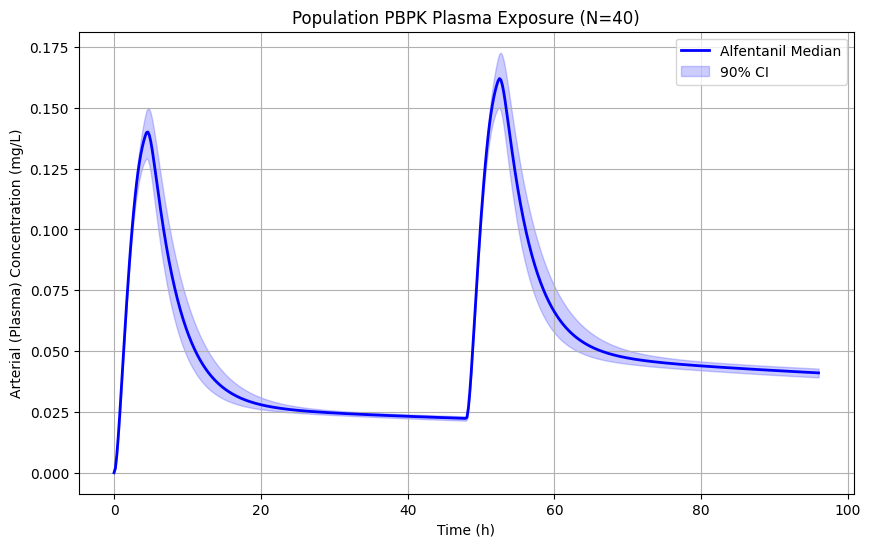


## 📉 Single Individual Plasma Profile (Last Drug)


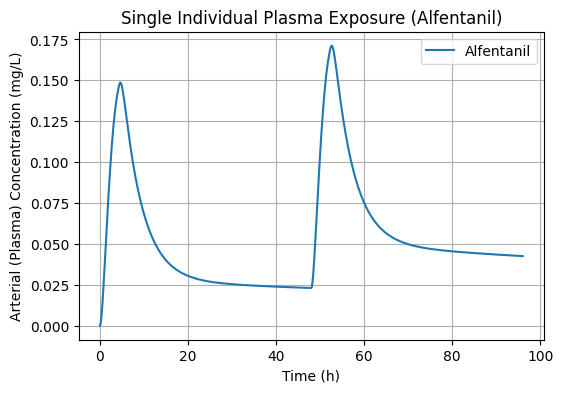

In [79]:
#@title Cell 3: Execution and Results Presentation

# This block executes the model using the parameters defined in Cell 2 and generates the output tables and plots.

final_report_list = []
plasma_profiles_data = {}
single_individual_metrics = []
last_C_art_single = None


# --- Run the Simulation Loop ---
for drug_params in DRUGS_TO_EVALUATE:
    single_res, pop_report_df, Cmax_pop, AUC_pop, t_eval_res, pop_profiles_2d, C_art_single_profile = run_and_evaluate_pbpk(
        drug_params,
        physiology_base,
        t_eval,
        n_individuals=n_pop_indiv
    )

    # Store the single profile for the last drug
    last_C_art_single = C_art_single_profile

    # Store results for table
    single_individual_metrics.append({
        "Drug": single_res['Drug'],
        "Cmax (mg/L)": single_res['Plasma Cmax (mg/L)'],
        "AUC (mg*h/L)": single_res['Plasma AUC (mg*h/L)'],
        "CL_total (L/h)": single_res['CL_total (L/h)'],
        "Tmax (h)": single_res['Tmax (h)'],
        "Hepatic Ext. Ratio": single_res['Hepatic Extraction Ratio'],
        "fa (Absorbed)": single_res.get('Fraction Absorbed (fa)', 0),
        "Bioavailability F": single_res.get('Emergent F', 0),
        "Type": "Single Individual"
    })

    pop_median_row = pop_report_df[pop_report_df['Type'] == "Population Median"].copy()

    final_report_list.append(single_res)

    # Combine Single and Population results into one clean table
    pop_report_df.index = pop_report_df['Type']
    pop_report_df = pop_report_df.drop(columns=['Drug', 'Type'])

    single_df = pd.DataFrame([single_individual_metrics[-1]]).set_index('Type')

    combined_summary = pd.concat([single_df, pop_report_df], sort=False)

    # Store profile data for plotting
    plasma_profiles_data[drug_params["name"]] = {
        'pop_profiles_2d': pop_profiles_2d,
        't_eval': t_eval_res
    }

def calculate_emergent_F(sol, dose, drug, phys):
    # Total drug that left the lumen and entered the gut tissue
    total_absorbed = sol.y[state_index["cm_absorbed"]][-1]
    fa = total_absorbed / dose

    # Calculate Hepatic Extraction (Eh)
    # Using the Well-Stirred model logic you already have:
    CL_H_eff, Eh = calculate_CL_H_eff(drug, phys, {"CYP3A4": 1.0, "CYP2D6": 1.0, "CYP2C9": 1.0})
    fh = 1 - Eh

    # Assuming no gut wall metabolism (fg = 1)
    fg = 1.0

    emergent_F = fa * fg * fh
    return emergent_F, fa, Eh

# --- Results Presentation ---

# 1. Combined Summary Table
print("📊 PBPK Simulation Results Summary")
print(f"### Results for: {DRUGS_TO_EVALUATE[-1]['name']}")

print(combined_summary[[
    "Cmax (mg/L)",
    "AUC (mg*h/L)",
    "CL_total (L/h)",
    "Tmax (h)",
    "Hepatic Ext. Ratio",
    "fa (Absorbed)",
    "Bioavailability F",
    "90% CI/GCV%"
]].to_markdown(numalign="left", stralign="left"))


# 2. Population Plot
print("\📈 Population Pharmacokinetic Profile")
plt.figure(figsize=(10, 6))

for drug_name, data in plasma_profiles_data.items():
    pop_profiles_2d = data['pop_profiles_2d']
    t_eval = data['t_eval']

    if pop_profiles_2d.shape[0] > 1:
    # axis=0 calculates across the individuals for every time poin
        median_plasma = np.percentile(pop_profiles_2d, 50, axis=0)
        lower_plasma = np.percentile(pop_profiles_2d, 5, axis=0)
        upper_plasma = np.percentile(pop_profiles_2d, 95, axis=0)

        plt.plot(t_eval, median_plasma, label=f'{drug_name} Median', color='blue', linewidth=2)
        plt.fill_between(t_eval, lower_plasma, upper_plasma, color='blue', alpha=0.2, label='90% CI')
    else:
        print(f"Warning: {drug_name} has insufficient concentration data for plotting (only {pop_profiles_2d.shape[0]} runs available).")

plt.xlabel("Time (h)")
plt.ylabel("Arterial (Plasma) Concentration (mg/L)")
plt.title(f"Population PBPK Plasma Exposure (N={n_pop_indiv})")
plt.legend()
plt.grid(True)
plt.show()

# 3. Individual Plot (Last Drug)
print("\n## 📉 Single Individual Plasma Profile (Last Drug)")

plt.figure(figsize=(6, 4))
plt.plot(t_eval, last_C_art_single, label=f'{DRUGS_TO_EVALUATE[-1]["name"]}')
plt.xlabel("Time (h)")
plt.ylabel("Arterial (Plasma) Concentration (mg/L)")
plt.title(f"Single Individual Plasma Exposure ({DRUGS_TO_EVALUATE[-1]['name']})")
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# @title 🔬 Sensitivity Analysis: Cmax Drivers
# ============================================================

# ---- Global override helpers ----

def with_temp_attr(obj, key, new_value):
    old_value = obj[key]
    obj[key] = new_value
    return old_value

def with_temp_nested(obj, keys, new_value):
    ref = obj
    for k in keys[:-1]:
        ref = ref[k]
    old_value = ref[keys[-1]]
    ref[keys[-1]] = new_value
    return old_value


def run_single_Cmax(drug_params, physiology_base, t_eval):
    """Run a single-individual simulation and return Cmax."""
    enzyme_ref = {"CYP3A4": 1.0, "CYP2D6": 1.0, "CYP2C9": 1.0}
    phys = sample_physiology(physiology_base, drug_params)

    y0 = np.zeros(n_states)
    if drug_params["route"] == "oral":
        y0[state_index["stomach_lumen"]] = drug_params["dose_mg"]
    else:
        y0[state_index["venous"]] = drug_params["dose_mg"]

    sol = solve_ivp(
        pbpk_ode,
        [0, t_eval[-1]],
        y0,
        t_eval=t_eval,
        args=(phys, drug_params, enzyme_ref),
        method="LSODA"
    )

    C_art = sol.y[state_index["arterial"]] / phys["blood"]["V_art"]
    return np.max(C_art)


def sensitivity_analysis(drug_base, physiology_base, t_eval, perturbation=0.2):
    """
    Local log-sensitivity analysis on Cmax.
    perturbation = fractional change (e.g. 0.2 = ±20%)
    """
    base_drug = copy.deepcopy(drug_base)
    Cmax_ref = run_single_Cmax(base_drug, physiology_base, t_eval)

    results = []

    def evaluate(label, modifier_fn):
        drug_p = copy.deepcopy(base_drug)
        phys_p = copy.deepcopy(physiology_base)

        modifier_fn(drug_p, phys_p)

        Cmax_new = run_single_Cmax(drug_p, phys_p, t_eval)
        S = ((Cmax_new - Cmax_ref) / Cmax_ref) / perturbation

        results.append({
            "Parameter": label,
            "Cmax_ref": Cmax_ref,
            "Cmax_new": Cmax_new,
            "Sensitivity": S
        })

    # ---- Drug parameters ----
    evaluate("KA", lambda d, p: d.__setitem__("KA", d["KA"] * (1 + perturbation)))
    evaluate("fu_plasma", lambda d, p: d.__setitem__("fu_plasma", d["fu_plasma"] * (1 + perturbation)))
    evaluate("CLint_CYP3A4", lambda d, p: d["CLint"].__setitem__("CYP3A4", d["CLint"]["CYP3A4"] * (1 + perturbation)))
    evaluate("CLint_CYP2D6", lambda d, p: d["CLint"].__setitem__("CYP2D6", d["CLint"]["CYP2D6"] * (1 + perturbation)))
    evaluate("CL_renal", lambda d, p: d.__setitem__("CL_renal", d["CL_renal"] * (1 + perturbation)))
    evaluate("Bioavailability_F", lambda d, p: d["physchem"].__setitem__("F", d["physchem"]["F"] * (1 + perturbation)))


    # effective permeability and solubility
    def bump_Peff(d, p):
      d["physchem"]["P_eff_transcellular"] *= (1 + perturbation)
      V_gut_total = sum(p["organs"][seg]["V"] for seg in GI_segments)
      d["KA"] = calculate_KA_from_Permeability(
      d["physchem"]["P_eff_transcellular"],
      V_gut_total
    )
    def bump_solubility(d, p):
      d["physchem"]["solubility_mg_per_mL"] *= (1 + perturbation)

    evaluate("Effective Permeability (P_eff)", bump_Peff)
    evaluate("Solubility (mg/mL)", bump_solubility)




    # ---- Lipophilicity → Kp ----
    def bump_logP(d, p):
        new_logP = d["physchem"]["logP"] * (1 + perturbation)
        d["physchem"]["logP"] = new_logP
        for organ in d["Kp"]:
            d["Kp"][organ] *= (1 + perturbation)

    evaluate("logP → Kp", bump_logP)

    # ---- Hard-coded physiology assumptions ----
    evaluate(
        "Cardiac Output",
        lambda d, p: p.__setitem__(
            "cardiac_output",
            p["cardiac_output"] * (1 + perturbation)
        )
    )

    evaluate(
        "Liver Blood Flow Fraction",
        lambda d, p: p["organs"]["liver"].__setitem__(
            "Q_frac",
            p["organs"]["liver"]["Q_frac"] * (1 + perturbation)
        )
    )
# ---- Additional Physiological Parameters ----

    evaluate(
        "Kidney Blood Flow Fraction",
        lambda d, p: p["organs"]["kidney"].__setitem__(
            "Q_frac",
            p["organs"]["kidney"]["Q_frac"] * (1 + perturbation)
        )
    )

    for seg in ["stomach", "duodenum", "jejunum", "ileum"]:
        evaluate(
            f"{seg.capitalize()} Blood Flow Fraction",
            lambda d, p, s=seg: p["organs"][s].__setitem__(
                "Q_frac",
                p["organs"][s]["Q_frac"] * (1 + perturbation)
            )
        )

    # ---- Organ Volumes ----
    for organ in physiology_base["organs"]:
        evaluate(
            f"{organ.capitalize()} Volume",
            lambda d, p, o=organ: p["organs"][o].__setitem__(
                "V",
                p["organs"][o]["V"] * (1 + perturbation)
            )
        )

    # ---- Blood Volumes ----
    evaluate(
        "Arterial Blood Volume",
        lambda d, p: p["blood"].__setitem__(
            "V_art",
            p["blood"]["V_art"] * (1 + perturbation)
        )
    )

    evaluate(
        "Venous Blood Volume",
        lambda d, p: p["blood"].__setitem__(
            "V_ven",
            p["blood"]["V_ven"] * (1 + perturbation)
        )
    )
# ---- GI Transit Kinetics ----

    global T_rate_stomach, T_rate_intestine

    base_T_stomach = 0.2
    base_T_intestine = 2.0

    def bump_T_stomach(d, p):
        global T_rate_stomach
        T_rate_stomach = base_T_stomach * (1 + perturbation)

    def bump_T_intestine(d, p):
        global T_rate_intestine
        T_rate_intestine = base_T_intestine * (1 + perturbation)

    evaluate("Gastric Emptying Rate", bump_T_stomach)
    evaluate("Intestinal Transit Rate", bump_T_intestine)

    # Restore
    T_rate_stomach = base_T_stomach
    T_rate_intestine = base_T_intestine

        # ---- GI Lumen Volumes ----
    for seg in GI_LUMEN_VOLUMES:
        def bump_lumen(d, p, s=seg):
            GI_LUMEN_VOLUMES[s] *= (1 + perturbation)

        evaluate(f"{seg.capitalize()} Lumen Volume", bump_lumen)

        # Restore
        GI_LUMEN_VOLUMES[seg] /= (1 + perturbation)
# ---- CLint Scaling Assumptions ----

    evaluate(
        "MPPGL",
        lambda d, p: d["physchem"].__setitem__(
            "MPPGL",
            d["physchem"]["MPPGL"] * (1 + perturbation)
        )
    )

    evaluate(
        "Liver Weight",
        lambda d, p: d["physchem"].__setitem__(
            "liver_weight",
            d["physchem"]["liver_weight"] * (1 + perturbation)
        )
    )
    df = pd.DataFrame(results)
    df["|Sensitivity|"] = df["Sensitivity"].abs()
    df = df.sort_values("|Sensitivity|", ascending=False)

    return df


# ============================================================
# ▶️ Run Sensitivity Analysis
# ============================================================

sens_df = sensitivity_analysis(
    new_drug_params,
    physiology_base,
    t_eval,
    perturbation=0.2
)

print("\n🔬 Cmax Sensitivity Ranking (±20%)")
print(sens_df[["Parameter", "Sensitivity"]].to_markdown(index=False))



🔬 Cmax Sensitivity Ranking (±20%)
| Parameter                      |   Sensitivity |
|:-------------------------------|--------------:|
| logP → Kp                      |   -0.832614   |
| Liver Volume                   |   -0.642128   |
| Jejunum Volume                 |   -0.586777   |
| Kidney Volume                  |   -0.541449   |
| Venous Blood Volume            |    0.523968   |
| Gastric Emptying Rate          |   -0.492087   |
| Arterial Blood Volume          |   -0.44987    |
| Brain Volume                   |   -0.430788   |
| Jejunum Lumen Volume           |   -0.346092   |
| Cardiac Output                 |   -0.321905   |
| Bioavailability_F              |    0.298885   |
| MPPGL                          |   -0.28804    |
| CLint_CYP3A4                   |   -0.283847   |
| fu_plasma                      |   -0.279138   |
| CL_renal                       |   -0.27384    |
| Effective Permeability (P_eff) |    0.249006   |
| Muscle Volume                  |   -0.246518 